In [2]:
import pickle
import joblib
import ast, os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from v1dd_public import ARTIFACT_DIR
from allen_v1dd.client import OPhysClient
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import LinearSegmentedColormap

In [3]:
## plotting parameters
from matplotlib import rcParams
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"

fontsize=20

In [4]:
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]
H5_DIR = os.path.join(ARTIFACT_DIR, 'stimulus_analyses_v2.h5')
DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs")
client =  OPhysClient(DATA_DIR)

In [5]:
csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    # remove duplicate neurons
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

## FIGURE 4A

In [6]:
res = ['mouse_id',
        'frac_resp_dgf',
        'frac_resp_dgw',
        'frac_res_to_ns118', # please note the other fraction frac_resp_ns118 is from Chase h5 which is incorrect
        'frac_res_to_ns12', # please note the other fraction frac_resp_ns12 is from Chase h5 which is incorrect
        'frac_resp_nm',
        'z'
       ]
features = cell_info[res]  # features is a dataframe with the 7 response reliability fractions (columns) for every cell (rows) across all mice

features = features.rename(columns = {
       'frac_resp_dgf':'DGF',
       'frac_resp_dgw':'DGW',
       'frac_res_to_ns118':'NI118',
       'frac_res_to_ns12':'NI12',
       'frac_resp_nm':'NM',
       'z': 'depth'},)

0.25
0.2857142857142857
0.375
0.125
0.4333333333333333


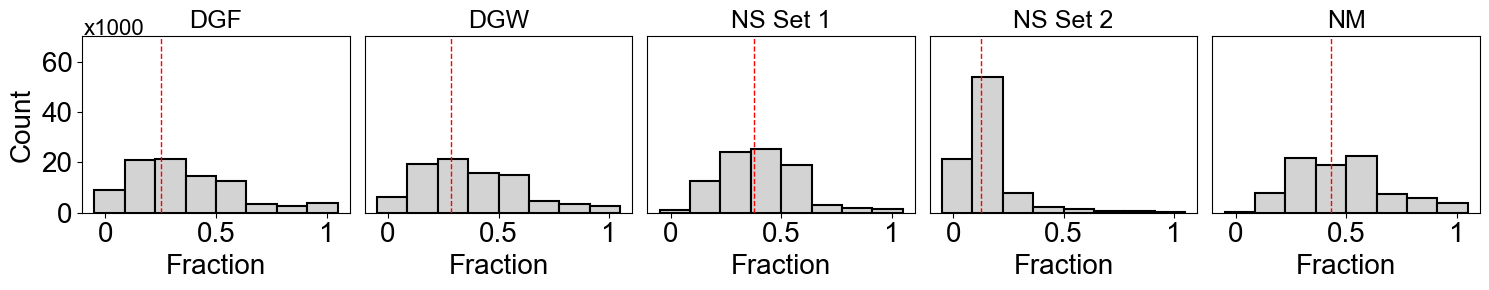

In [7]:
feature_labels = ['DGF', 'DGW', 'NI118', 'NI12', 'NM']
feature_titles = ['DGF', 'DGW', 'NS Set 1', 'NS Set 2', 'NM']

plt.figure(figsize=(15,3))
fontsize = 20
for n in range(len(feature_labels)):
    plt.subplot(1, len(feature_labels), n+1)
    bins = np.linspace(-0.05, 1.05, 9).tolist()
    plt.hist(features[feature_labels[n]], bins=bins, edgecolor='black', linewidth=1.5, color='lightgray')
    
    median_value = np.median(features[feature_labels[n]])
    print(median_value)
    plt.axvline(median_value, color='r', linestyle='dashed', linewidth=1)  
    plt.title(feature_titles[n], fontsize=fontsize-2)
    plt.xlabel("Fraction", fontsize=fontsize)
    plt.ylim([0, 70000])
    plt.yticks([0, 20000, 40000, 60000], ['0', '20', '40', '60'], fontsize=fontsize)
    plt.xticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=fontsize)    
    if n == 0:
        plt.ylabel("Count", fontsize=fontsize)
        plt.text(-0.1, 73000, 'x1000', verticalalignment='center', fontsize=fontsize-4)
    else:
        plt.yticks([])

    plt.tight_layout()

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', 'FIG4A_fraction_histograms.svg'), dpi=300)

## FIGURE 4B

In [16]:
res2 = ['mouse_id',
        'frac_resp_dgf',
        'frac_resp_dgw',
        'frac_res_to_ns118', # please note the other fraction frac_resp_ns118 is from Chase h5 which is incorrect
        'frac_res_to_ns12', # please note the other fraction frac_resp_ns12 is from Chase h5 which is incorrect
        'frac_resp_nm',
        'z',
        'column'
       ]
features_resp = cell_info[res2]  # features_resp is a dataframe with the 7 response reliability fractions (columns) for every cell (rows) across all mice

features_resp = features_resp.rename(columns = {
       'frac_resp_dgf':'DGF',
       'frac_resp_dgw':'DGW',
       'frac_res_to_ns118':'NI118',
       'frac_res_to_ns12':'NI12',
       'frac_resp_nm':'NM',
       'z': 'depth'},)

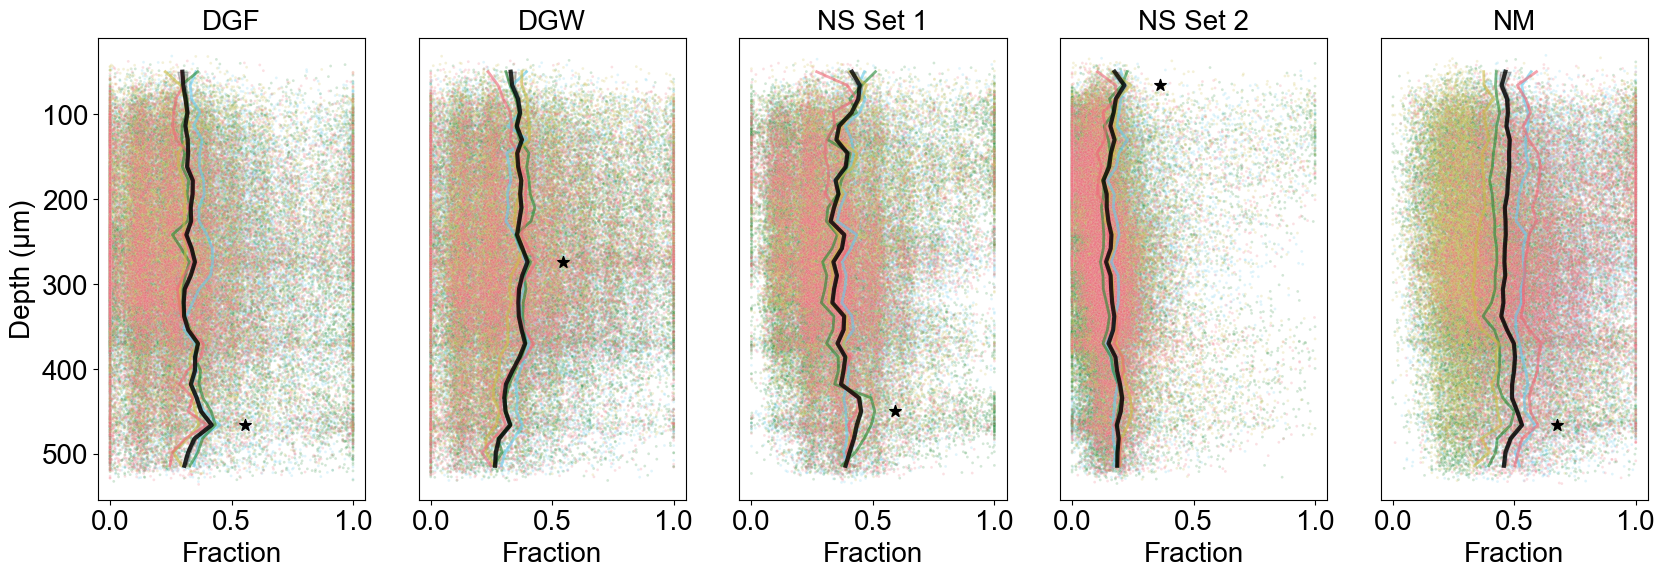

In [18]:
#### Plotting depth distributions of response reliabilities for each mouse
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}

features_resp = features_resp[(features_resp['depth'] < 515) & (features_resp['depth'] != 500)]  # remove 3p data

# Some parameters for the plot
z_values = features_resp['depth'].unique()
z_values = np.array(z_values)
z_values = np.sort(z_values)
stims = ['DGF', 'DGW', 'NI118', 'NI12', 'NM']
titles = ['DGF', 'DGW', 'NS Set 1', 'NS Set 2', 'NM']
n_stims = len(stims)

fig, axs = plt.subplots(1, n_stims, figsize=(20, 6))
fontsize = 20


# Iterate through each stimulus type and plot the results for all the mice
for stim_idx, stim_type in enumerate(stims):
    ax = axs[stim_idx]

    sns.lineplot(
        data=features_resp,
        x=stim_type,
        y='depth',
        hue='mouse_id',
        palette=mouse_colors,
        linewidth=2, 
        errorbar=None, 
        alpha=0.6, 
        orient='y', 
        markers=True,
        ax=ax,
        legend=False
    )


    sns.lineplot(data=features_resp, 
        x=stim_type, 
        y='depth', 
        color='black', 
        estimator='mean',
        err_style='band', 
        errorbar='se', 
        linewidth=3, 
        alpha=0.8, 
        orient='y', 
        ax=ax, 
        legend=False
    )

    # Put asterisk next to the depth where the max mean
    mean_feature_df = features_resp.groupby(by=['mouse_id', 'column', 'depth'])[stim_type].mean()
    mean_feature_df = mean_feature_df.reset_index()
    sub_df = mean_feature_df.groupby('depth')[stim_type].mean().reset_index()
    sub_array = sub_df[stim_type].values
    ax.scatter(sub_array.max() + 0.15, sub_df.iloc[np.where(sub_array == sub_array.max())].depth.values[0], 
        color='black', marker='*', s=75, edgecolor='black', zorder=1)
    

    # Scatterplot of all the individual points
    temp_df = features_resp.copy()
    temp_df['depth'] = temp_df['depth'] + np.random.normal(0, 7, size=len(temp_df))
    temp_df[stim_type] = temp_df[stim_type] + np.random.normal(0, 0.04, size=len(temp_df))
    temp_df[stim_type] = np.clip(temp_df[stim_type], 0, 1)

    sns.scatterplot(data=temp_df,
        x=stim_type,
        y='depth',
        hue='mouse_id',
        palette=mouse_colors,
        s=4,
        alpha=0.2,
        ax=ax,
        legend=False,
        zorder=0,
    )

    ax.set_title(titles[stim_idx], fontsize=fontsize)
    ax.set_xlabel('Fraction', fontsize=fontsize)
    ax.set_ylabel("Depth (µm)", fontsize=fontsize) if stim_idx == 0 else ax.set_ylabel(" ")
    ax.set_yticks([]) if stim_idx != 0 else None
    ax.set_ylim(z_values.min() - 40, z_values.max() + 40)
    ax.tick_params(axis="both", which="major", labelsize=fontsize)
    ax.invert_yaxis()

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'FIG4B_resp_fractions_depth_trends_just2P.png'), transparent=True, dpi=500)

## FIGURE 4C

In [9]:
res3 = ['frac_resp_dgf', 'frac_resp_dgw', 'frac_res_to_ns118', 'frac_res_to_ns12', 'frac_resp_nm']
stim_names = ['Full-field Drifting Gratings', 'Windowed Drifting Gratings', 'Natural Images Set 1', 'Natural Images Set 2', 'Natural Movie']

features = cell_info[res3]
features = features.rename(columns = {
       'frac_resp_dgf':'DGF',
       'frac_resp_dgw':'DGW',
       'frac_res_to_ns118':'NI118',
       'frac_res_to_ns12':'NI12',
       'frac_resp_nm':'NM'})

all_features = [features[f] for f in features.columns.tolist()]
features_stacked = np.vstack(all_features).T

To make TSNE plots, first get shared embedding -- takes around 25 minutes on my PC to run the cell below

In [49]:
perplexity = 50
early_exaggeration = 12.0
learning_rate = 500

tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        early_exaggeration=early_exaggeration,
        learning_rate=learning_rate,
        random_state=42
    )
    
embedding = tsne.fit_transform(features_stacked)

KeyboardInterrupt: 

In [12]:
colors = []
colors.extend([(i/255, i/255, i/255) for i in np.linspace(80, 200, 128)])
colors.extend([(1, i/255, i/255) for i in np.linspace(200, 30, 128)])
custom_gray_cmap = LinearSegmentedColormap.from_list("custom_gray_to_red", colors, N=256)

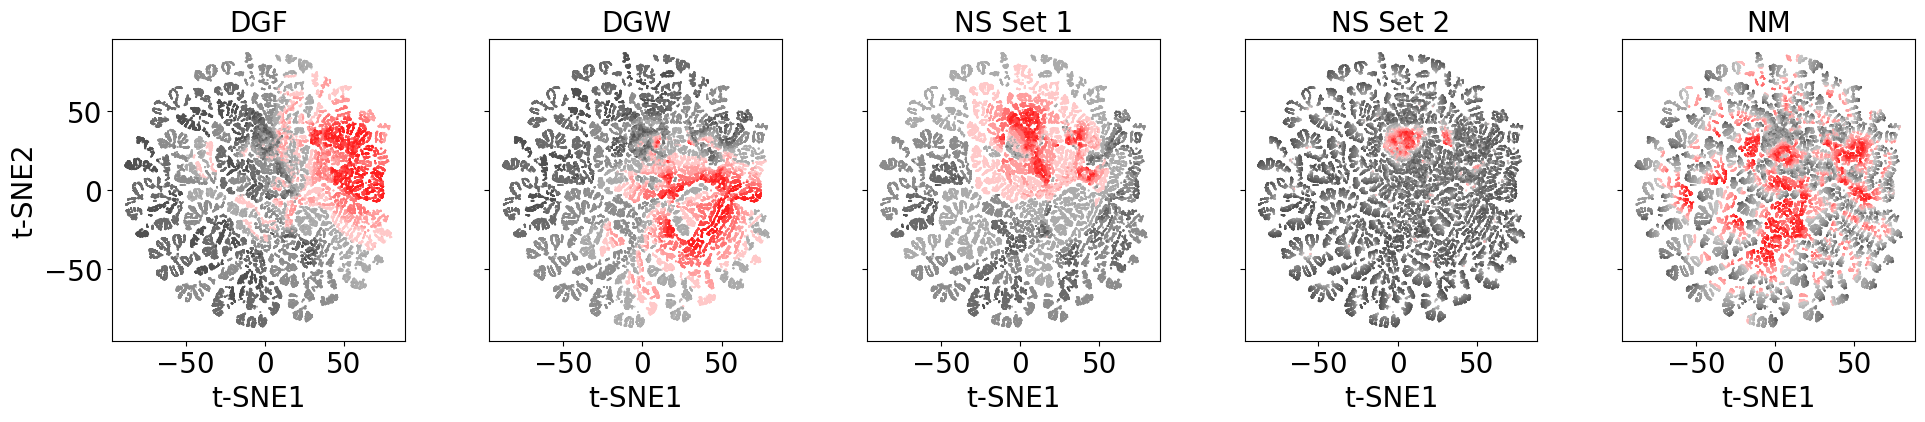

In [ ]:
fig, axs = plt.subplots(1, len(stim_names), figsize=(20, 4), sharex=True, sharey=True)
fontsize = 20

stim_names = ['Full-field Drifting Gratings', 'Windowed Drifting Gratings', 'Natural Images Set 1', 'Natural Images Set 2', 'Natural Movie']
titles = ['DGF', 'DGW', 'NS Set 1', 'NS Set 2', 'NM']
unique_labels = np.unique(features_stacked)
label_to_color = {label: idx for idx, label in enumerate(unique_labels)}

for idx, stim_title in enumerate(titles):
    ax = axs[idx]
    X_subset_labels = features_stacked[:, idx]
    color_labels = np.array([label_to_color[label] for label in X_subset_labels])
    sc = ax.scatter(
            x=embedding[:, 0],
            y=embedding[:, 1],
            c=color_labels,
            cmap=custom_gray_cmap,
            alpha=1,
            s=0.1,

        )

    # plt.colorbar(sc, ax=ax)
    ax.set_aspect('equal')
    ax.set_title(stim_title, fontsize=fontsize)
    ax.set_xlabel('t-SNE1', fontsize=fontsize) 
    ax.set_ylabel('t-SNE2', fontsize=fontsize) if idx == 0 else None
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tight_layout()
# plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', 'FIG4C_tSNE_clusters_by_stimulus_responsiveness.svg'), dpi=300)
plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', 'FIG4C_tSNE_clusters_by_stimulus_responsiveness.png'), transparent=True, dpi=500)


## FIGURE 4D-G + SUPPLEMENTARY GMM CLUSTERINGS

In [10]:
res2 = ['frac_resp_dgf',
        'frac_resp_dgw',
        'frac_res_to_ns118',
        'frac_res_to_ns12',
        'frac_resp_nm'
       ]
features = cell_info[res2]

features.rename(columns = {
       'frac_resp_dgf':'DGF',
       'frac_resp_dgw':'DGW',
       'frac_res_to_ns118':'NI118',
       'frac_res_to_ns12':'NI12',
       'frac_resp_nm':'NM'},
        inplace = True)

all_features = [features[f] for f in features.columns.tolist()]
features_stacked = np.vstack(all_features).T
X = features_stacked

/tmp/ipykernel_3520073/3524945909.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.rename(columns = {


In [11]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    return -estimator.bic(X)

In [18]:
features_copy = features.copy()
features_copy['DGF'] = (features['DGF'] - features['DGF'].mean()) / features['DGF'].std()
features_copy['DGW'] = (features['DGW'] - features['DGW'].mean()) / features['DGW'].std()
features_copy['NI118'] = (features['NI118'] - features['NI118'].mean()) / features['NI118'].std()
features_copy['NI12'] = (features['NI12'] - features['NI12'].mean()) / features['NI12'].std()
features_copy['NM'] = (features['NM'] - features['NM'].mean()) / features['NM'].std()
all_features = [features_copy[f] for f in features_copy.columns.tolist()]
features_stacked = np.vstack(all_features).T
X = features_stacked

min_components = 1
max_components = 30
param_grid = {
    'n_components': np.arange(min_components, max_components + 1)
}
gmm = GaussianMixture(random_state=5, n_init=3)
grid_search = GridSearchCV(gmm, param_grid, cv=5, n_jobs=25, scoring=gmm_bic_score, verbose=3)
grid_search.fit(X)
print(f"Best number of clusters: {grid_search.best_params_['n_components']}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ..............n_components=1;, score=-236682.124 total time=   0.1s
[CV 2/5] END ..............n_components=1;, score=-251778.939 total time=   0.3s
[CV 3/5] END ..............n_components=1;, score=-264310.865 total time=   0.4s[CV 5/5] END ..............n_components=1;, score=-244246.684 total time=   0.4s

[CV 4/5] END ..............n_components=1;, score=-239932.201 total time=   0.4s
[CV 3/5] END ..............n_components=2;, score=-248319.244 total time=   1.3s
[CV 2/5] END ..............n_components=2;, score=-236676.594 total time=   1.5s
[CV 5/5] END ..............n_components=2;, score=-230720.148 total time=   1.7s
[CV 3/5] END ..............n_components=3;, score=-242313.501 total time=   2.0s
[CV 1/5] END ..............n_components=2;, score=-225071.809 total time=   2.2s
[CV 4/5] END ..............n_components=2;, score=-223679.540 total time=   2.8s
[CV 2/5] END ..............n_components=3;, sco

In [ ]:
clusters = grid_search.predict(X)
n_clusters = grid_search.best_params_['n_components']

mean_reliability_per_cluster = np.zeros((n_clusters, 5))
groups_in_clusters = np.zeros((n_clusters, 5))
cluster_assignments = np.zeros((n_clusters, 5))
mean_reliability_per_cluster_raw = np.zeros((n_clusters, 5))

# use actual reliabilities for cluster characterization
all_features_raw = [features[f] for f in features.columns.tolist()]
features_stacked_raw = np.vstack(all_features_raw).T
X_raw = features_stacked_raw

threshold = -0.674 # corresponds to 25th percentile
# threshold = 0 # corresponds to 50th percentile
# threshold = 0.385 # corresponds to 65th percentile
# threshold = 0.842 # corresponds to 80th percentile
# threshold = 1.282 # corresponds to 90th percentile
# threshold = 1.645 # corresponds to 95th percentile
# threshold = 2.326 # corresponds to 99th percentile

group_names = ['DGF', 'DGW', 'NS1', 'NS2', 'NM']
cluster_assignments_names = []
for cluster in range(n_clusters):
    name = ''
    for g in range(5):
        cell_ind_in_cluster = np.where(clusters == cluster)[0]
        reliabilities_in_cluster = X[cell_ind_in_cluster, g]
        mean_reliability_per_cluster[cluster, g] = np.nanmean(reliabilities_in_cluster)

        reliabilities_in_cluster_raw = X_raw[cell_ind_in_cluster, g]
        mean_reliability_per_cluster_raw[cluster, g] = np.nanmean(reliabilities_in_cluster_raw)

        if mean_reliability_per_cluster[cluster, g] >= threshold: 
            cluster_assignments[cluster, g] = 1
            name += group_names[g] + '-'
            
    if name == '':
        name = '-'
    cluster_assignments_names.append(name[:-1])

In [121]:
order = [
    '',
    'DGF',
    'DGW',
    'NS1',
    'NS2',
    'NM',
    'DGF-DGW',
    'DGF-NS1',
    'DGF-NS2',
    'DGF-NM',
    'DGW-NS1',
    'DGW-NS2',
    'DGW-NM',
    'NS1-NS2',
    'NS1-NM',
    'NS2-NM',
    'DGF-DGW-NS1',
    'DGF-DGW-NS2',
    'DGF-NS1-NS2',
    'DGW-NS1-NS2',
    'DGF-DGW-NM',
    'DGF-NS1-NM',
    'DGF-NS2-NM',
    'DGW-NS1-NM',
    'DGW-NS2-NM',
    'NS1-NS2-NM',
    'DGF-DGW-NS1-NM',
    'DGF-DGW-NS2-NM',
    'DGF-NS1-NS2-NM',
    'DGW-NS1-NS2-NM',
    'DGF-DGW-NS1-NS2',
    'DGF-DGW-NS1-NS2-NM'
]

# sort by custom order
sorted_indices = np.zeros((n_clusters))
count = 0
for item in order:
    if item in cluster_assignments_names:
        indices = np.where(np.array(cluster_assignments_names) == item)[0]
        # print(item, indices)
        for index in indices:
            sorted_indices[count] = index
            count += 1
    sorted_indices = sorted_indices.astype(int)

for item in cluster_assignments_names:
    if item not in order:
        print(f'ERROR: REDO YOU FORGOT TO INCLUDE: {item}')

cluster_assignments_names_sorted = np.array(cluster_assignments_names)[sorted_indices]
mean_reliability_per_cluster_sorted = mean_reliability_per_cluster[sorted_indices]
mean_reliability_per_cluster_raw_sorted = mean_reliability_per_cluster_raw[sorted_indices]

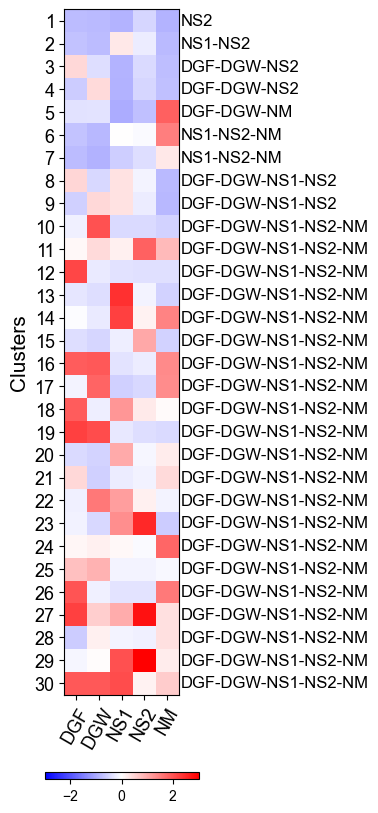

In [122]:
plt.figure(figsize=(20, 10))
cm = plt.imshow(mean_reliability_per_cluster_sorted, cmap='bwr', vmin=-3, vmax=3)
cbar = plt.colorbar(cm, fraction=0.01, pad=0.1, location='bottom')

for i, cluster_class in enumerate(cluster_assignments_names_sorted):
    if cluster_class == '':
        cluster_class = 'None'
    plt.text(4.6, i, cluster_class, fontsize=12, verticalalignment='center', horizontalalignment='left')

plt.yticks(np.arange(0, mean_reliability_per_cluster_sorted.shape[0], 1), np.arange(1, mean_reliability_per_cluster_sorted.shape[0]+1, 1), fontsize=13)
plt.xticks(np.arange(0, mean_reliability_per_cluster_sorted.shape[1], 1), ['DGF', 'DGW', 'NS1', 'NS2', 'NM'], fontsize=13, rotation=60)
plt.ylabel('Clusters', fontsize=15)

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'FIG4D_GMM_clustered_heatmap_thresh={threshold}.svg'), dpi=300)

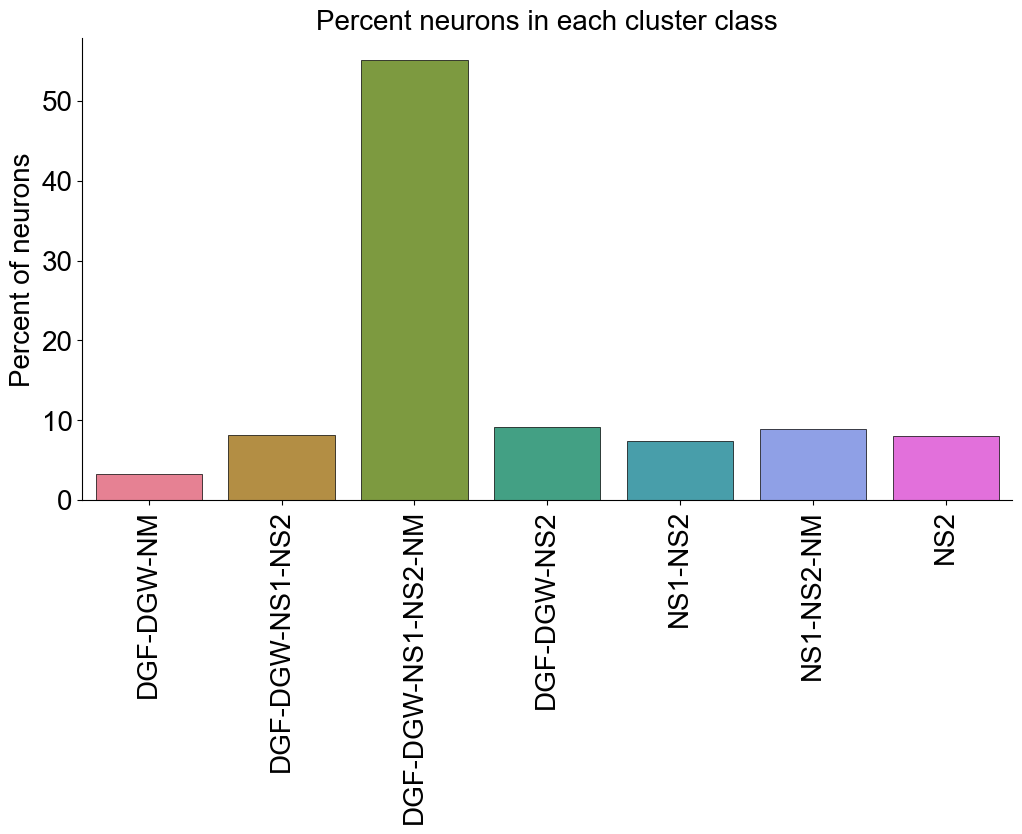

In [123]:
weights = {name: 0 for name in np.unique(cluster_assignments_names_sorted)}

for clust in range(n_clusters):
    # print(cluster_assignments_names[clust], weights[cluster_assignments_names[clust]])
    cell_ind_in_cluster = np.where(clusters == clust)[0]
    weights[cluster_assignments_names[clust]] += (len(cell_ind_in_cluster) / len(clusters)) * 100

weights_df = pd.DataFrame.from_dict(weights, orient='index', columns=['weight']).reset_index()

plt.figure(figsize=(12, 6))
bars = sns.barplot(weights_df, x='index', y='weight', palette='husl', edgecolor='black', linewidth=0.5)
plt.xticks(np.arange(len(weights)), list(weights.keys()), rotation=90, fontsize=20);
plt.xlabel('')
# plt.yticks(np.arange(0, 25, 5), fontsize=20);
plt.ylabel('Percent of neurons', fontsize=20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Percent neurons in each cluster class', fontsize=20)

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'FIG4E_GMM_clustered_barplot_thresh={threshold}.svg'), dpi=300)

In [124]:
mice_ids = cell_info['mouse_id'].values
mouse_mapping = {
    'slc2': 'Mouse 1',
    'slc4': 'Mouse 2',
    'slc5': 'Mouse 3',
    'teto1': 'Mouse 4'
}
mice_ids = np.array([mouse_mapping[str(x)] for x in mice_ids])

In [125]:
x = ['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4']
weights_mice = {name: np.zeros(4) for name in np.unique(cluster_assignments_names_sorted)}

for clust in range(n_clusters):
    for mouse in np.unique(mice_ids):
        mouse_indices = np.where(mice_ids == mouse)[0]

        cell_ind_in_cluster = np.where((clusters == clust) & (mice_ids == mouse))[0]
        weights_mice[f'{cluster_assignments_names[clust]}'][int(mouse[-1]) - 1] += (len(cell_ind_in_cluster) / len(mouse_indices)) * 100

In [127]:
weights_mice

{'DGF-DGW-NM': array([2.62187971, 3.03560529, 1.68813427, 5.854463  ]),
 'DGF-DGW-NS1-NS2': array([ 6.66778355,  7.81688708, 13.92466823,  4.56091528]),
 'DGF-DGW-NS1-NS2-NM': array([66.17523873, 49.72126144, 43.45725995, 60.85858586]),
 'DGF-DGW-NS2': array([ 5.05528564, 12.87894201, 13.02693208,  5.30818388]),
 'NS1-NS2': array([ 5.37359692,  7.47100712, 11.73887588,  4.95774067]),
 'NS1-NS2-NM': array([10.5252136 ,  6.74262462,  4.78142077, 14.16202845]),
 'NS2': array([ 3.58100184, 12.33367243, 11.38270882,  4.29808287])}

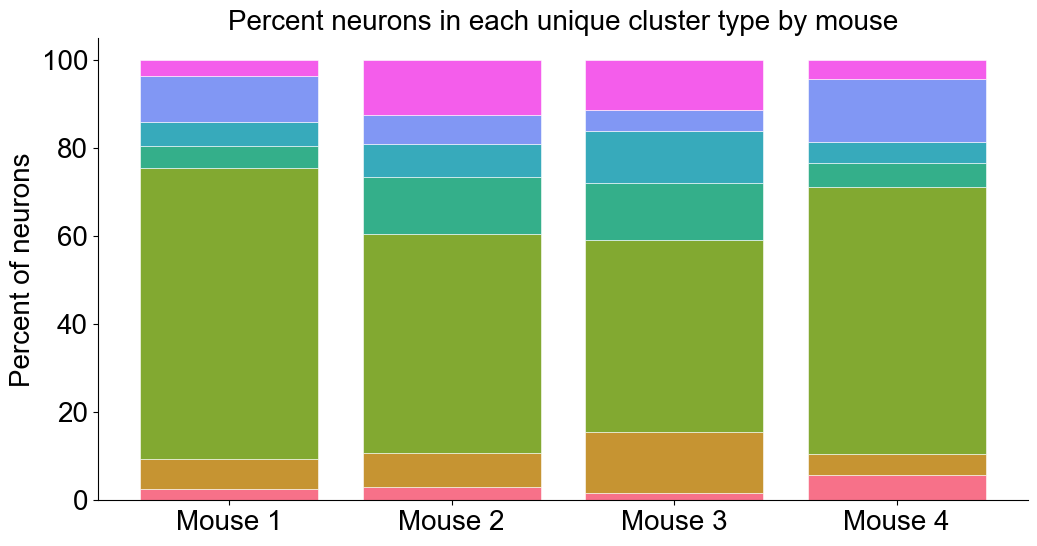

In [128]:
color_palette = sns.husl_palette(len(weights_mice.keys()))
x = ['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4']

plt.figure(figsize=(12, 6))
# plt.bar(x, weights_mice[''], color=color_palette[0], edgecolor='white', linewidth=0.4)
# bottom = weights_mice['']
bottom = np.zeros(len(x))

for key, values in weights_mice.items():
    if key == '':
        continue
    
    plt.bar(x, values, bottom=bottom, color=color_palette[list(weights_mice.keys()).index(key)], edgecolor='white', linewidth=0.4)
    bottom = bottom + values

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.ylabel('Percent of neurons', fontsize=20)
plt.title('Percent neurons in each unique cluster type by mouse', fontsize=20)

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'FIG4F_GMM_clustered_barplot_by_mouse_thresh={threshold}.svg'), dpi=300)

In [129]:
x = ['Mouse 1', 'Mouse 2', 'Mouse 3', 'Mouse 4']
depths_list = np.sort(cell_info.z.unique()) 
all_depths = cell_info.z.values
depths_list = depths_list[(depths_list < 515) & (depths_list != 500)] # just look at 2p data 
weights_depth = {name: np.zeros(len(depths_list)) for name in np.unique(cluster_assignments_names_sorted)}

for clust in range(n_clusters):
    for idx, depth in enumerate(depths_list):
        depth_indices = np.where(all_depths == depth)[0]

        cell_ind_in_cluster = np.where((clusters == clust) & (all_depths == depth))[0]
        weights_depth[f'{cluster_assignments_names[clust]}'][idx] += (len(cell_ind_in_cluster) / len(depth_indices)) * 100

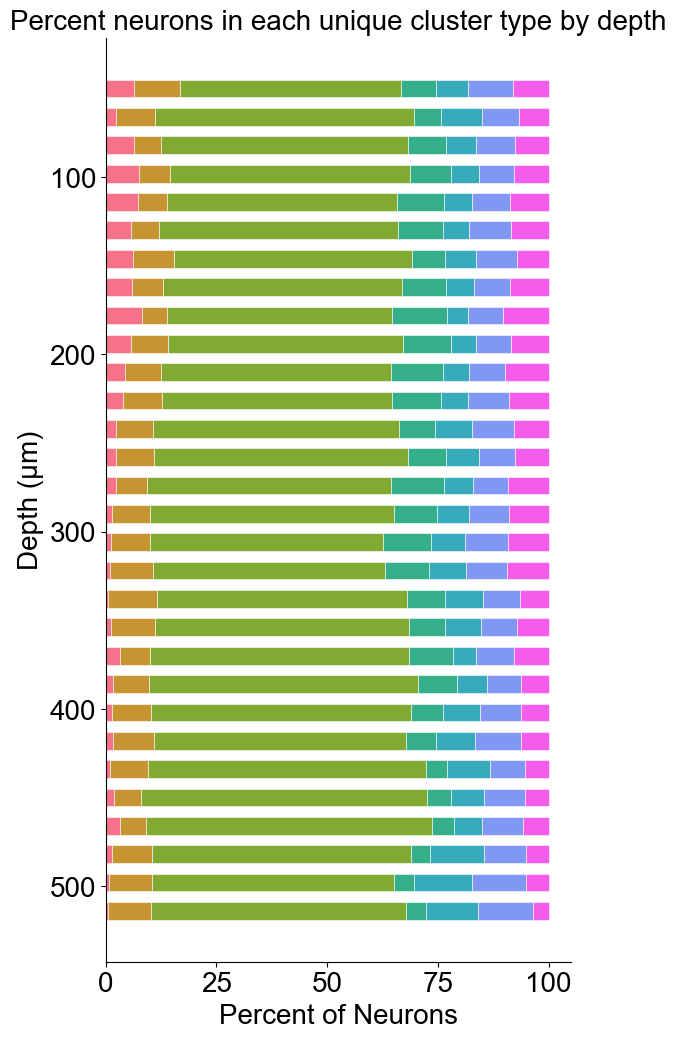

In [131]:
color_palette = sns.husl_palette(len(weights_mice.keys()))

plt.figure(figsize=(6, 12))
# plt.barh(depths_list, weights_depth[''], color=color_palette[0], height=10, edgecolor='white', linewidth=0.4)
# left = weights_depth['']
left = np.zeros(len(depths_list))

for key, values in weights_depth.items():
    if key == '':
        continue
    
    plt.barh(depths_list, values, left=left, color=color_palette[list(weights_mice.keys()).index(key)], height=10, edgecolor='white', linewidth=0.4)
    left = left + values

plt.gca().invert_yaxis()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Percent of Neurons', fontsize=20)
plt.ylabel('Depth (μm)', fontsize=20)
plt.title('Percent neurons in each unique cluster type by depth', fontsize=20)

plt.savefig(os.path.join(ARTIFACT_DIR, 'figures', f'FIG4G_GMM_clustered_barplot_by_depth_thresh={threshold}.svg'), dpi=300)